# Computing on the Dynex Neuromorphic Platform: Image Classification

Computing on Quantum or neuromorphic systems is fundamentally different than using traditional hardware and is a very active area of research with new algorithms surfacing almost on a weekly basis. In this article we will use the Dynex SDK (beta) to perform an image classification task using a transfer learning approach based on a Quantum-Restricted-Boltzmann-Machine ("QRBM") based on the paper "A hybrid quantum-classical approach for inference on restricted Boltzmann machines". It is a step-by-step guide on how to utilize neuromorphic computing with Python using PyTorch. This example is just one of multiple possibilities to perform machine learning tasks. However, it can be easily adopted to other use cases.

In [2]:
import math
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.nn import Module
from torchvision import transforms
from sklearn.linear_model import LogisticRegression

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Import Dynex Pytorch layer classes

The Dynex Platform can be used as a Neuromorphic PyTorch layer. We import the required classes:

In [8]:
from HybridQRBM.pytorchdnx import dnx
from HybridQRBM.optimizers import RBMOptimizer
from HybridQRBM.samplers import DynexSampler

## Parameters

We define the training hyperparameters. Neuromorphic Dynex layers evolve extremely fast towards an nearly optimal ground state. We therefore only need a few training epochs for a fully trained model.

In [9]:
INIT_LR    = 1e-3  # initial loss rate for optimizer
BATCH_SIZE = 10000 # number of images per batch
EPOCHS     = 1     # number of training epochs
device = "cpu"     # no GPU needed, we compute on the Dynex Platform

## Define the PyTorch Model

In [10]:
optimizer = RBMOptimizer(
                learning_rate=0.05,
                momentum=0.9,
                decay_factor=1.00005,
                regularizers=()
            );

sampler = DynexSampler(mainnet=True, 
               num_reads=100000, 
               annealing_time=200,  
               debugging=False, 
               logging=True, 
               num_gibbs_updates=1, 
               minimum_stepsize=0.002);


We define a model with just one Dynex neuromorphic layer. This layer is designed to find energy ground states for the entire batch of images - all these are computed fully parallel on the Dynex Platform. Technically, it is a QRBM (Quantum Restricted Boltzmann Machine) Layer returning hidden node weights. To classify we will apply a simple logistic regression model based on the hidden layers of this layer.

In [11]:
class QModel(nn.Module):
    def __init__(self, n_hidden, steps_per_epoch, sampler, optimizer):
        super().__init__();
        # Dynex Neuromporphic layer
        self.dnxlayer = dnx(n_hidden, steps_per_epoch, sampler=sampler, optimizer=optimizer); 
        
    def forward(self, x):
        x = self.dnxlayer(x);
        return x

## Load MNIST Dataset

PyTorch comes by default with the MNIST reference dataset.

In [12]:

class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255 / 255.  

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  

data_transformer = transforms.Compose([
        transforms.ToTensor(),
        ThresholdTransform(thr_255=128) 
    ])

In [13]:
from torchvision.datasets import MNIST
trainData = MNIST(root="data", train=True, download=True, transform=data_transformer)
testData = MNIST(root="data", train=False, download=True, transform=data_transformer) 
print("[INFO] MNIST dataset lodaed")

[INFO] MNIST dataset lodaed


In [14]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

## Model Training

The model accumulates all 60,000 train images and processes the sampling in parallel for the entire epoch:

In [15]:
steps_per_epoch = len(trainDataLoader.dataset) // BATCH_SIZE
# Define model with 300 hidden nodes:
model = QModel(300, steps_per_epoch, sampler, optimizer); 

In [16]:
for e in range(1, EPOCHS+1):
    print('EPOCH',e,'of',EPOCHS);
    # set the model in training mode
    model.train()
    # loop over the training set
    for (x, y) in trainDataLoader:
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = model(x);
    
print('FOUND MODEL ACCURACY:',np.array(model.dnxlayer.acc).max(),'%')

╭────────────┬───────────┬───────────┬─────────┬────────┬─────────┬───────┬───────┬───────────┬──────────────╮
│   DYNEXJOB │   ELAPSED │   WORKERS │   CHIPS │      ✔ │   STEPS │   LOC │     ✔ │    ENERGY │            ✔ │
├────────────┼───────────┼───────────┼─────────┼────────┼─────────┼───────┼───────┼───────────┼──────────────┤
│       3927 │      0.80 │        14 │  351456 │ 101408 │     200 │ 49296 │ 49480 │ 888846747 │ 883276358.00 │
╰────────────┴───────────┴───────────┴─────────┴────────┴─────────┴───────┴───────┴───────────┴──────────────╯
╭───────────┬───────────────┬─────────┬────────┬──────────────┬───────────┬───────────────┬──────────╮
│    WORKER │       VERSION │   CHIPS │    LOC │       ENERGY │   RUNTIME │   LAST UPDATE │   STATUS │
├───────────┼───────────────┼─────────┼────────┼──────────────┼───────────┼───────────────┼──────────┤
│ 130400088 │ 2.3.0.OZM.124 │   16128 │  49480 │ 888846747.00 │  0.05 min │    29.00s ago │  STOPPED │
├───────────┼───────────────┼────

[DYNEX] READING  40 VOLTAGES...


progress:   0%|          | 0/40 [00:00<?, ?it/s]

[DYNEX] SAMPLESET LOADED
DynexQRBM PyTorch Layer | applying sampling result... 60000 x 784
DynexQRBM PyTorch Layer | SME: 0.009717 ACCURACY: 99.028318%
FOUND MODEL ACCURACY: 99.0283181717132 %


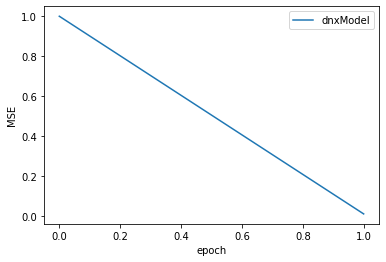

[1.0, 0.009716818282868035]


In [18]:
# visualize progress:
plt.figure()
plt.plot(model.dnxlayer.errors, label='dnxModel')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()
print(model.dnxlayer.errors)

## visualize test dataset:

1  batches total 10000 images in total, one batch 10000 images


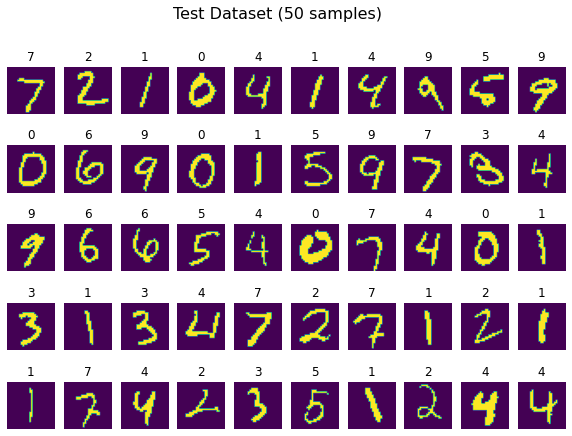

In [61]:
num_samp = 0;
num_batches = 0;
for batch_idx, (inputs, targets) in enumerate(testDataLoader):
    num_samp += len(inputs);
    num_batches += 1;
    
print(num_batches,' batches total', num_samp,'images in total, one batch',len(inputs),'images')

# we use data from the last batch:
fig = plt.figure(figsize=(10, 7));
fig.suptitle('Test Dataset (50 samples)', fontsize=16)
rows = 5;
columns = 10;

for j in range(0,50):
    fig.add_subplot(rows, columns, j+1)
    plt.imshow(inputs[j][0])
    marker=str(targets[j].tolist())
    plt.title(marker)
    plt.axis('off');
    
plt.show();

## Transfer Learning: Classifyer with Logistic Regression from RBM's Hidden Layer 

In [58]:
data = [];
data_labels = [];
error = 0;
for i in range(0, 150):
    inp = np.array(inputs[i].flatten().tolist()); 
    tar = np.array(targets[i].tolist())
    data.append(inp)
    data_labels.append(tar)
data = np.array(data)
data_labels = np.array(data_labels)

In [59]:
# extract hidden layers from RBM:
hidden, prob_hidden = model.dnxlayer.sampler.infer(data)

In [60]:
# Logistic Regression classifier on hidden nodes:
t = hidden * prob_hidden
clf = LogisticRegression(max_iter=10000)
clf.fit(t, data_labels)
predictions = clf.predict(t)
print('Accuracy:', (sum(predictions == data_labels) / data_labels.shape[0]) * 100,'%')

Accuracy: 99.33333333333333 %


In [49]:
# inspect predictions:
print('target   :',data_labels[:30])
print('predicted:',predictions[:30])

target   : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
predicted: [7 2 1 0 4 1 4 9 4 9 0 6 9 0 1 5 9 7 8 4 9 6 6 5 4 0 7 4 0 1]


## Image reconstruction with the RBM

In [50]:
_, features = model.dnxlayer.sampler.predict(data, num_particles=10,num_gibbs_updates=1)

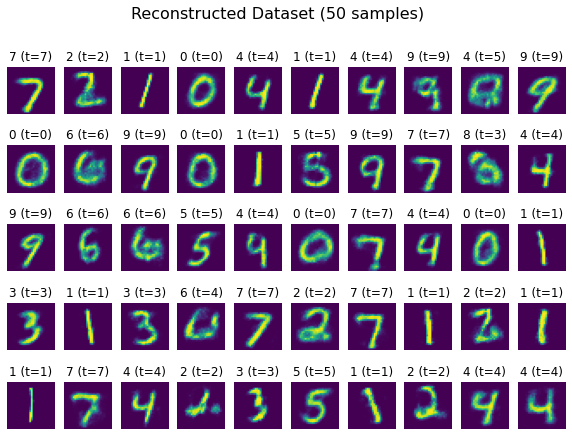

In [51]:
fig = plt.figure(figsize=(10, 7));
fig.suptitle('Reconstructed Dataset (50 samples)', fontsize=16)
rows = 5;
columns = 10;
for i in range(0,50):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(features[i].reshape(28,28))
    marker=str(predictions[i])+' (t='+str(data_labels[i])+')'
    plt.title(marker)
    plt.axis('off');
plt.show()

## Save Model

In [62]:
torch.save(model, './checkpoint/ckpt.pth')

## Load Model and Predict

In [63]:
testmodel = torch.load('./checkpoint/ckpt.pth');

In [64]:
# verify that model was correctly loaded:
testmodel.dnxlayer.weights == model.dnxlayer.weights

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [65]:
_, features = testmodel.dnxlayer.sampler.predict(data, num_particles=10,num_gibbs_updates=1)

In [67]:
# extract hidden layers from RBM:
hidden, prob_hidden = testmodel.dnxlayer.sampler.infer(data)
# Logistic Regression classifier on hidden nodes:
from sklearn.linear_model import LogisticRegression
t = hidden * prob_hidden
clf = LogisticRegression(max_iter=10000)
clf.fit(t, data_labels)
predictions = clf.predict(t)
print('Accuracy:', (sum(predictions == data_labels) / data_labels.shape[0]) * 100,'%')

Accuracy: 99.33333333333333 %


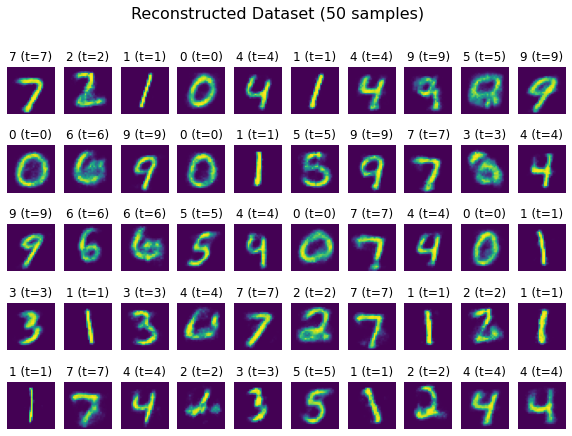

In [66]:
fig = plt.figure(figsize=(10, 7));
fig.suptitle('Reconstructed Dataset (50 samples)', fontsize=16)
rows = 5;
columns = 10;
for i in range(0,50):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(features[i].reshape(28,28))
    marker=str(predictions[i])+' (t='+str(data_labels[i])+')'
    plt.title(marker)
    plt.axis('off');
plt.show()